In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 11s 0us/step


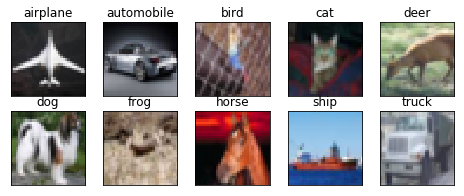

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [7]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
from keras.callbacks import Callback
import os
import keras.backend as K

In [0]:
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])
      

In [11]:
from keras import optimizers
model1 = Sequential()
model1.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Convolution2D(10, 1, 1))

model1.add(AveragePooling2D(pool_size = (4,4)))
model1.add(Flatten())


model1.add(Activation('softmax'))

# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# sgd = optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=False)


# model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])


W0723 06:57:18.161691 140288738129792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
W0723 06:57:18.207519 140288738129792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 06:57:18.214815 140288738129792 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random

In [0]:
#model.summary()

In [0]:
# from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(zoom_range=0.0, 
#                              horizontal_flip=False,preprocessing_function=get_random_eraser(v_l=0, v_h=1))


# # train the model
# start = time.time()
# # Train the model
# lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(train_features.shape[0]/128))
# model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
#                                  samples_per_epoch = train_features.shape[0], nb_epoch = 3, 
#                                  validation_data = (test_features, test_labels), verbose=1,callbacks=[lr_finder])
# end = time.time()
# print ("Model took %0.2f seconds to train"%(end - start))
# # plot model history
# plot_model_history(model_info)
# # compute test accuracy
# print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [14]:
lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(train_features.shape[0]/128))
model1.fit(train_features,train_labels,callbacks=[lr_finder]) 

W0723 06:58:07.310860 140288738129792 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
10880/50000 [=====>........................] - ETA: 1:14 - loss: 3.6494 - acc: 0.2181

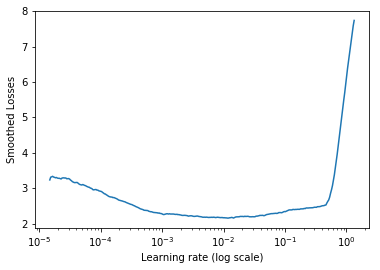

In [15]:
lr_finder.plot_smoothed_loss()
#lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(train_features.shape[0]/128))

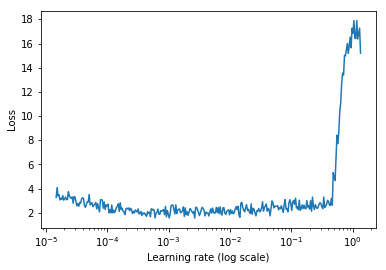

In [16]:
lr_finder.plot()

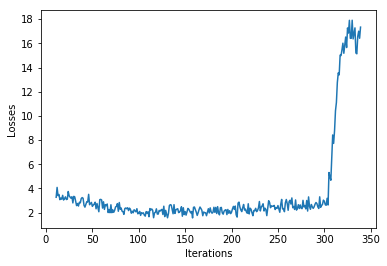

In [17]:
lr_finder.plot_loss()

In [21]:
lr_finder = LR_Finder(start_lr=1e-4, end_lr=1e-2, step_size=np.ceil(train_features.shape[0]/128))
model1.fit(train_features,train_labels,callbacks=[lr_finder])


Epoch 1/1
39040/50000 [======================>.......] - ETA: 17s - loss: 141.1034 - acc: 0.0989

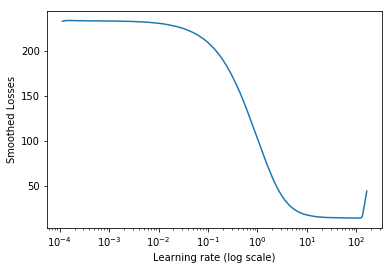

In [22]:
lr_finder.plot_smoothed_loss()

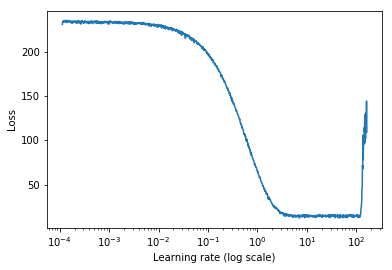

In [23]:
lr_finder.plot()

In [27]:
lr_finder = LR_Finder(start_lr=1e-1, end_lr=1, step_size=np.ceil(train_features.shape[0]/128))
model1.fit(train_features,train_labels,callbacks=[lr_finder])

Epoch 1/1
44032/50000 [=========================>....] - ETA: 9s - loss: 34.4672 - acc: 0.1003

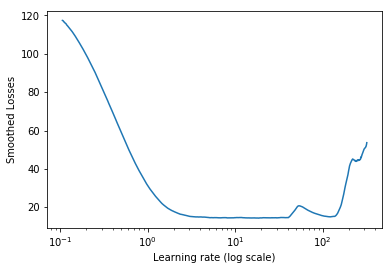

In [28]:
lr_finder.plot_smoothed_loss()

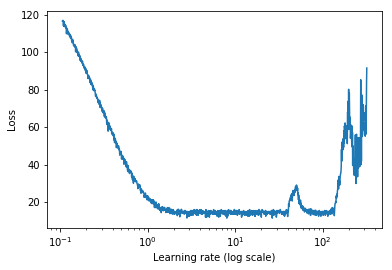

In [29]:
lr_finder.plot()

In [30]:
lr_finder = LR_Finder(start_lr=1e-3, end_lr=1, step_size=np.ceil(train_features.shape[0]/128))
model1.fit(train_features,train_labels,callbacks=[lr_finder])

Epoch 1/1
23392/50000 [=============>................] - ETA: 43s - loss: 44.0150 - acc: 0.1021

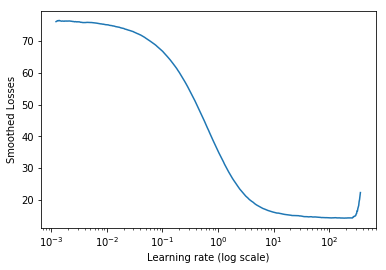

In [31]:
lr_finder.plot_smoothed_loss()

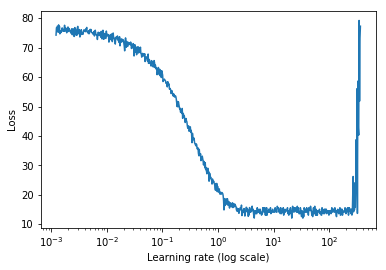

In [32]:
lr_finder.plot()

In [34]:
from keras import optimizers
model1 = Sequential()
model1.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Convolution2D(10, 1, 1))

model1.add(AveragePooling2D(pool_size = (4,4)))
model1.add(Flatten())


model1.add(Activation('softmax'))

# Compile the model
#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
sgd = optimizers.SGD(lr=1e-1, decay=1e-6, momentum=0.9, nesterov=False)


model1.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), ke

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 29s 74ms/step - loss: 2.0272 - acc: 0.3225 - val_loss: 1.8329 - val_acc: 0.3540
Epoch 2/100
390/390 [==============================] - 27s 69ms/step - loss: 1.4700 - acc: 0.4902 - val_loss: 1.5351 - val_acc: 0.4832
Epoch 3/100
390/390 [==============================] - 26s 68ms/step - loss: 1.2274 - acc: 0.5917 - val_loss: 1.2961 - val_acc: 0.5775
Epoch 4/100
390/390 [==============================] - 26s 68ms/step - loss: 1.0968 - acc: 0.6435 - val_loss: 1.1815 - val_acc: 0.6285
Epoch 5/100
390/390 [==============================] - 26s 68ms/step - loss: 1.0037 - acc: 0.6806 - val_loss: 0.9742 - val_acc: 0.6963
Epoch 6/100
390/390 [==============================] - 26s 68ms/step - loss: 0.9488 - acc: 0.7044 - val_loss: 1.1299 - val_acc: 0.6603
Epoch 7/100
390/390 [==============================] - 26s 67ms/step - loss: 0.9048 - acc: 0.7220 - val_loss: 1.0347 - val_acc: 0.6930
Epoch 8/100
390/390 [==============================] - 

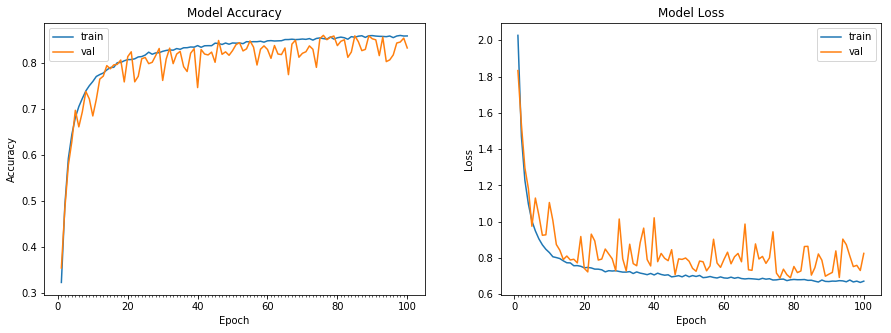

NameError: ignored

In [36]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,preprocessing_function=get_random_eraser(v_l=0, v_h=1))


# train the model
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy


In [37]:
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model1))

Accuracy on test data is: 83.16


In [0]:
model1.save_weights('cifar_assign_11.hdf5')